# Food volume estimation from monocular video

In [1]:
import matplotlib.pyplot as plt
import os
import subprocess
import open3d as o3d
import cv2
import numpy as np
from scipy.spatial import ConvexHull
import shutil


from src.extract_frames import extract_frames
from src.read_dmap import loadDMAP
from src.select_views import select_views
from src.segment_view import segment_view

from FastSAM.fastsam import FastSAM


Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


### 0. Loading the data

In [24]:
source_type = "video"

name = "garlic_coin"
cwd = os.getcwd()
input_path = os.path.abspath("./videos")
if not (name + ".mp4") in os.listdir(input_path):
    input_path = os.path.abspath("./images/{}".format(name))
    source_type = "image"
else:
    video_path = os.path.abspath("./videos/{}.mp4".format(name))


output_path = "./results/{}/".format(name)
frame_path = "{}frames/".format(output_path)

if not os.path.exists(output_path):
    os.mkdir(output_path)

if not os.path.exists(frame_path):
    os.mkdir(frame_path)

print(source_type)

video


### 1. Frame extraction from video

For the first step we have to extract the frames from the video. On top of that, we also have to save image metadata on each frame. For that, we use an image captured with the same phone. 

In [37]:
if source_type == "video":
    n_frames = 30
    reference_path = "./reference-images/samu-reference.jpg"
    extract_frames(video_path, reference_path, frame_path, n_frames)
else:
    n_frames = len(os.listdir(input_path))
    # copy images to frame path
    for i, image in enumerate(os.listdir(input_path)):
        extension = image.split(".")[-1]
        shutil.copy(input_path + "/" + image, frame_path + str(i).rjust(3, '0') + "." + extension)

30 frames saved in: ./results/garlic_coin/frames/


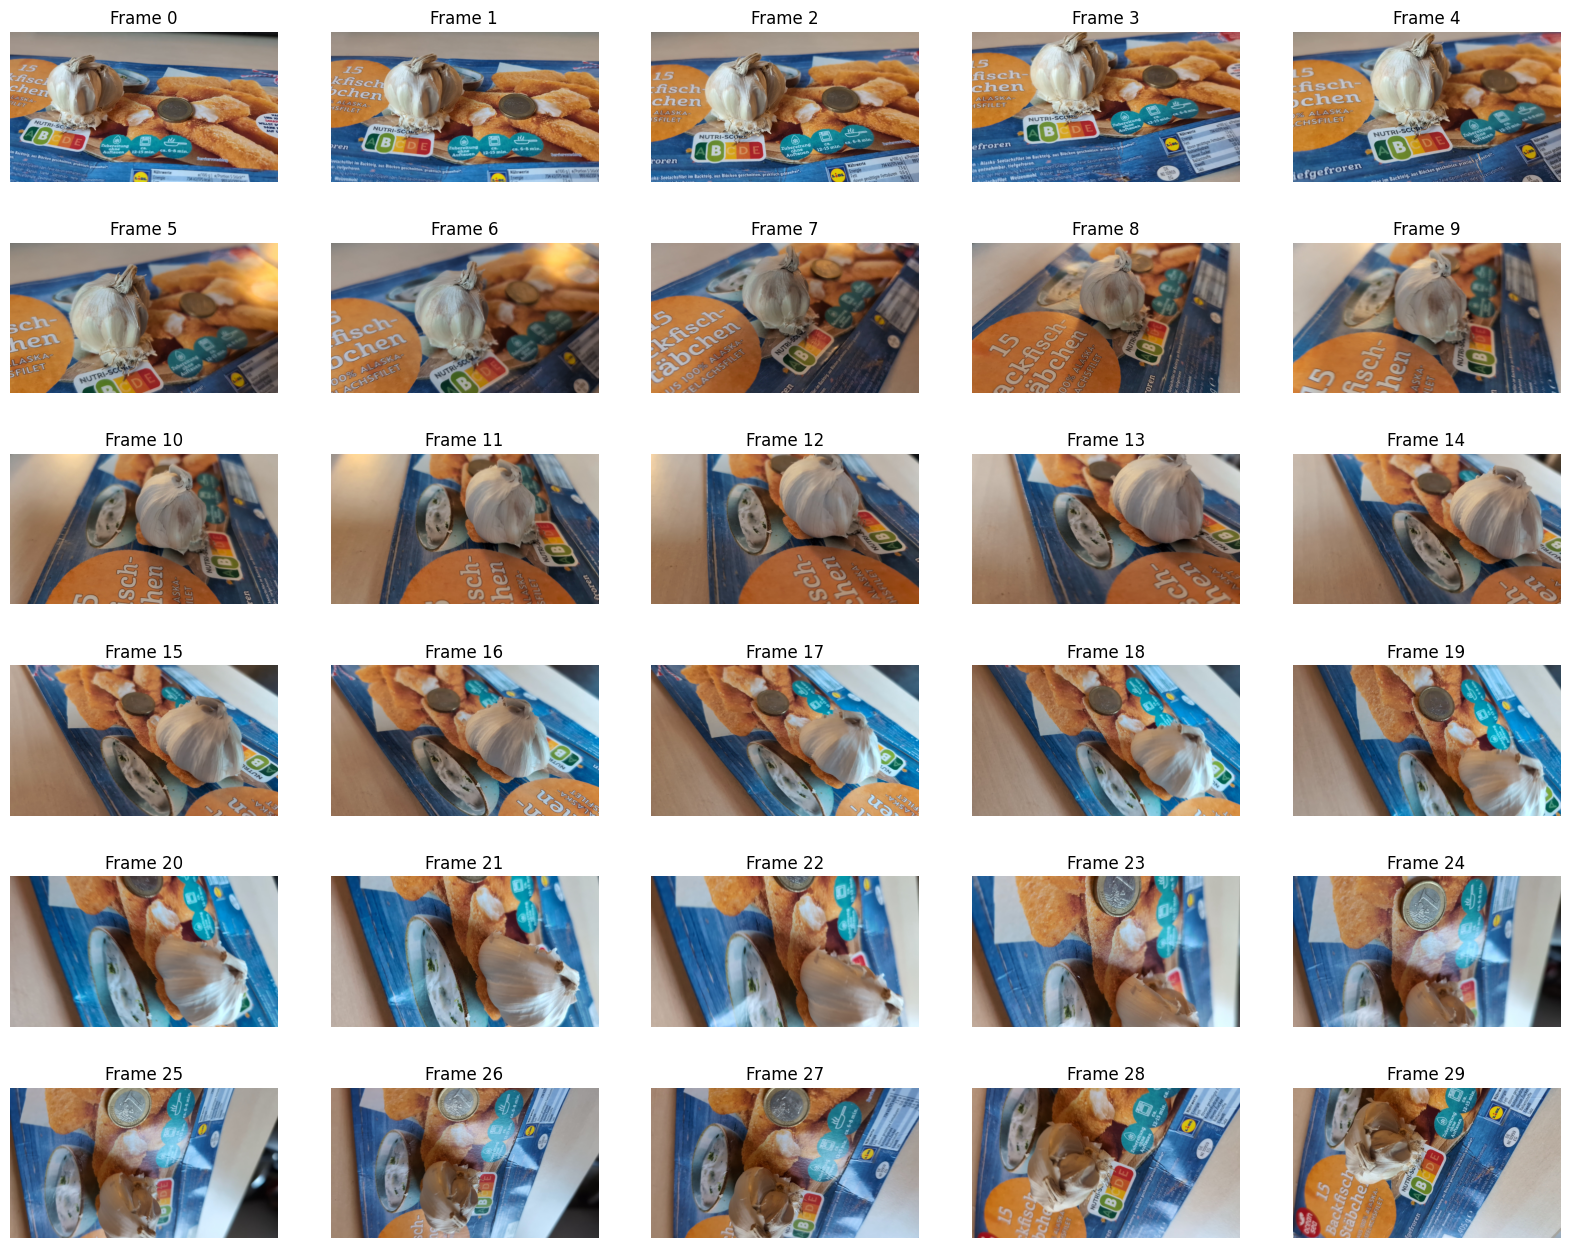

In [26]:
# Visualization of the extracted frames

fig, axs = plt.subplots(
    n_frames // 5 + (0 if n_frames % 5 == 0 else 1),
    5,
    figsize=(20, 16)
)

img_paths = [img for img in os.listdir(frame_path) if img.endswith(".jpg")]
for i, img in enumerate(img_paths):
    img = plt.imread(frame_path + "/" + img)
    axs[i//5, i%5].set_title("Frame {}".format(i))
    axs[i//5, i%5].imshow(img)
    axs[i//5, i%5].axis("off")

### 2. OpenMVG

In [6]:
# OpenMVG specific paths
OPENMVG_SFM_BIN = os.path.abspath("./OpenMVG")
CAMERA_DATABASE = os.path.abspath("./sensor_width_database")
camera_file_params = os.path.join(CAMERA_DATABASE, "sensor_width_camera_database.txt")
reconstruction_dir= os.path.join(output_path,"reconstruction_sequential")


matches_dir = os.path.join(output_path, "matches")
# Create the ouput/matches folder if not present
if not os.path.exists(matches_dir):
  os.mkdir(matches_dir)

In [38]:
print ("1. Intrinsics analysis...", end=" ")
pIntrisics = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_SfMInit_ImageListing"),  "-i", frame_path, "-o", matches_dir, "-d", camera_file_params, "-c", "3"] )
pIntrisics.wait()
print(" Done!")

print ("2. Computing features... ", end=" ")
pFeatures = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_ComputeFeatures"),  "-i", matches_dir+"/sfm_data.json", "-o", matches_dir, "-m", "SIFT", "-f" , "1"] )
pFeatures.wait()
print(" Done!")


print ("3. Computing matches... ", end=" ")
pMatches = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_ComputeMatches"),  "-i", matches_dir+"/sfm_data.json", "-o", matches_dir+"/matches.putative.bin", "-f", "1", "-n", "ANNL2"] )
pMatches.wait()
print(" Done!")


print ("4. Filtering matches... ", end=" ")
pFiltering = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_GeometricFilter"), "-i", matches_dir+"/sfm_data.json", "-m", matches_dir+"/matches.putative.bin" , "-g" , "f" , "-o" , matches_dir+"/matches.f.bin" ] )
pFiltering.wait()
print(" Done!")


print ("5. Doing Incremental reconstruction... ", end=" ") #set manually the initial pair to avoid the prompt question
pRecons = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_SfM"), "--sfm_engine", "INCREMENTAL", "--input_file", matches_dir+"/sfm_data.json", "--match_dir", matches_dir, "--output_dir", reconstruction_dir] )
pRecons.wait()
print(" Done!")


print ("6. Colorizing Structure... ", end=" ")
pRecons = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_ComputeSfM_DataColor"),  "-i", reconstruction_dir+"/sfm_data.bin", "-o", os.path.join(reconstruction_dir,"colorized.ply")] )
pRecons.wait()
print(" Done!")


print ("7. Computing Structure from Known Poses (robust triangulation)... ", end=" ")
pRecons = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_ComputeStructureFromKnownPoses"),  "-i", reconstruction_dir+"/sfm_data.bin", "-m", matches_dir, "-o", os.path.join(reconstruction_dir,"robust.ply")] )
pRecons.wait()
print(" Done!")


print ("8. Converting the sfm_data.bin to scene.mvs... ", end=" ")
pRecons = subprocess.Popen( [os.path.join(OPENMVG_SFM_BIN, "openMVG_main_openMVG2openMVS.exe"),  "-i", reconstruction_dir+"/sfm_data.bin", "-o", output_path+"\scene.mvs", "-d", output_path + "/undistorted"] )
pRecons.wait()
print(" Done!")

print("OpenMVG reconstruction finished!")


1. Intrinsics analysis...  Done!
2. Computing features...   Done!
3. Computing matches...   Done!
4. Filtering matches...   Done!
5. Doing Incremental reconstruction...   Done!
6. Colorizing Structure...   Done!
7. Computing Structure from Known Poses (robust triangulation)...   Done!
8. Converting the sfm_data.bin to scene.mvs...   Done!
OpenMVG reconstruction finished!


### 3. OpenMVS point cloud densification

In [40]:
OPENMVS = os.path.abspath("./OpenMVS")

os.chdir(output_path)
print("Densifiying point cloud... ", end=" ")
pRecons = subprocess.Popen( [os.path.join(OPENMVS, "DensifyPointCloud.exe"), ".\scene.mvs"] )
pRecons.wait()
print("Done!")
os.chdir(cwd)


Densifiying point cloud...  Done!


In [41]:
# Visualization of the full reconstruction

pcd = o3d.io.read_point_cloud(output_path + "scene_dense.ply")
print(f"Point cloud has {len(pcd.points)} points.")
o3d.visualization.draw_geometries([pcd])

Point cloud has 1780996 points.


### 3. View selection

After the reconstruction is done, we don't need all the views to reconstruct the segmented object. We read the depth maps and select the 10 frames with more information.

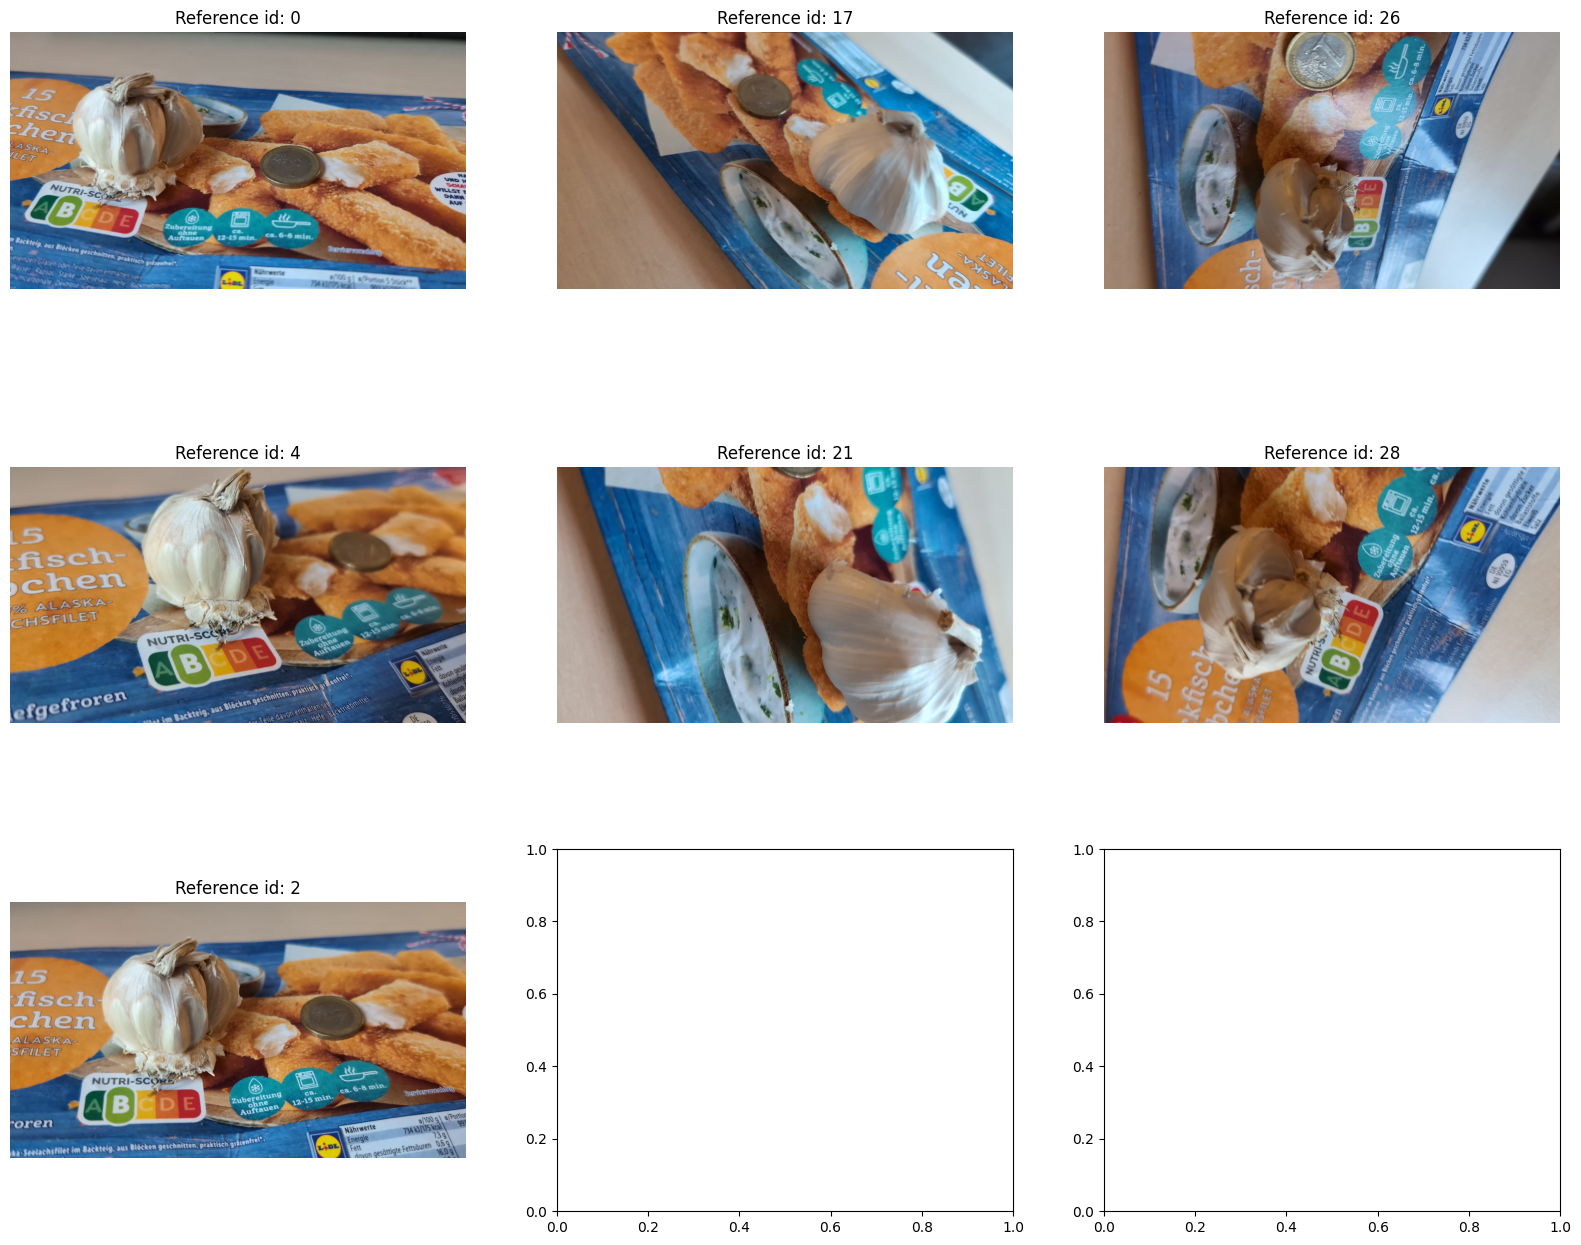

In [42]:
dmap_paths = [output_path + f for f in os.listdir(output_path) if f.endswith(".dmap")]

dmap_list = [loadDMAP(path) for path in dmap_paths]

# Set the views' reference ids that should be left out (e.g. the segmentation is not good enough for these views)
dmapsToLeaveOut = []

dmap_list = list(filter(lambda x: x["reference_view_id"] not in dmapsToLeaveOut, dmap_list))

n_views_for_segmentation = 7
selected_dmap = select_views(dmap_list, n_views_for_segmentation, [0], 1, 0.3)
fig, ax = plt.subplots(
    n_views_for_segmentation // 3 + (0 if n_views_for_segmentation % 3 == 0 else 1),
    3,
    figsize=(20, 16)
)

ax = ax.reshape(-1, 3)
for i, dmap in enumerate(selected_dmap):
    img = plt.imread(output_path + dmap["file_name"])
    ax[i//3, i%3].imshow(img)
    ax[i//3, i%3].axis("off")
    ax[i//3, i%3].set_title("Reference id: {}".format(dmap["reference_view_id"]))


### 4. 2D segmentation using FastSAM

We now segment the object in 3D by segmenting some views and building the 3D object back using only the segmented views. To segment the views, we use FastSAM on the undistorted images generated by OpenMVG.

In [ ]:
mask_path = os.path.join(output_path, 'masks')
if os.path.exists(mask_path):
    for file in os.listdir(mask_path):
        os.remove(os.path.join(mask_path, file))
else:
    os.makedirs(mask_path)

model = FastSAM('../models/FastSAM-s.pt')

for dmap in selected_dmap:
    
    file = dmap["file_name"]
    file_path = os.path.join(output_path, file)

    dmap["mask"] = segment_view(model, file_path)


fig, ax = plt.subplots(len(selected_dmap),2, figsize=(10, 30))
for i, dmap in enumerate(selected_dmap):
    img = plt.imread(output_path + dmap["file_name"])
    ax[i,0].imshow(img)
    ax[i,0].axis("off")
    ax[i,0].set_title(f"ID: {dmap['reference_view_id']}")
    ax[i,1].imshow(img * dmap["mask"].reshape(img.shape[0], img.shape[1], 1))
    ax[i,1].axis("off")

In [ ]:
# Set this to the reference views you want to redo if the segmentation was not good
referenceIdsToRedo = [21, 2]

dmapsToRedo = list(filter(lambda x: x["reference_view_id"] in referenceIdsToRedo, selected_dmap))

for dmap in dmapsToRedo:
    file_path = os.path.join(output_path, dmap["file_name"])
    dmap["mask"] = segment_view(model, file_path)

fig, ax = plt.subplots(len(dmapsToRedo), 2)

ax = ax.reshape(-1, 2)

for i, dmap in enumerate(dmapsToRedo):
    img = plt.imread(output_path + dmap["file_name"])
    ax[i,0].imshow(img)
    ax[i,0].axis("off")
    ax[i,0].set_title(dmap["file_name"])
    ax[i,1].imshow(img * dmap["mask"].reshape(img.shape[0], img.shape[1], 1))
    ax[i,1].axis("off") 
    ax[i,1].set_title(dmap["reference_view_id"])

### 5. 3D reconstruction of the segmented views

We read the .dmap files generated by OpenMVS to extract the depth maps and segment the object by only keeping the depth points on the mask. We then project each view to world coordinates and stack all point clouds into a single one.



In [ ]:
def build_pcd(rgb, depth, K, RT):
    width, height = depth.shape[:2]
    # Create Open3D RGBD image
    rgbd_image = o3d.geometry.RGBDImage.create_from_color_and_depth(
        o3d.geometry.Image(rgb), o3d.geometry.Image(depth), convert_rgb_to_intensity=False)

    # Convert intrinsic parameters to Open3D camera intrinsics
    intrinsic = o3d.camera.PinholeCameraIntrinsic()
    intrinsic.set_intrinsics(width, height, K[0, 0], K[1, 1], K[0, 2], K[1, 2])

    # Create Open3D point cloud from RGB-D image
    pcd = o3d.geometry.PointCloud.create_from_rgbd_image(rgbd_image,intrinsic, extrinsic=RT)
    return pcd

pcd_list = []
cam_list = []
for dmap in selected_dmap:

    depth = dmap["depth_map"] * 1000 # Correct the depth scale
    height, width = depth.shape
    img = cv2.imread(output_path + dmap["file_name"])
    img = cv2.resize(img, (width, height))
    mask = dmap["mask"]
    mask = cv2.resize(mask, (width, height))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    # cv2.imshow('image', mask*depth/np.max(depth))
    # cv2.waitKey(0)
    
    depth = depth*mask # Apply the mask to the depth map

    K = dmap["K"] # Intrinsic matrix
    R = dmap["R"] # Rotation matrix
    C = dmap["C"] # Translation vector

    # Create extrinsic matrix
    RT = np.eye(4)
    RT[:3, :3] = R
    RT[:3, 3] = -R @ C
    
    pcd = build_pcd(img, depth, K, RT)
    
    # Create the camera
    cameraLines = o3d.geometry.LineSet.create_camera_visualization(
        view_width_px=width, 
        view_height_px=height, 
        intrinsic=K,
        extrinsic=RT)

    pcd_list.append(pcd)
    cam_list.append(cameraLines)


plt.show()
# Merge all point clouds
pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(np.vstack([np.asarray(view.points) for view in pcd_list]))
pcd.colors = o3d.utility.Vector3dVector(np.vstack([np.asarray(view.colors) for view in pcd_list]))

# Save point cloud
o3d.io.write_point_cloud(output_path + "segmented_pointcloud.ply", pcd)



In [47]:
# Visualization of the segmented reconstruction
pcd = o3d.io.read_point_cloud(output_path + "segmented_pointcloud.ply")
o3d.visualization.draw_geometries([pcd])

### 6. Mesh reconstruction using PoissonRecon

Make sure to set the parameters for the outlier removal if necesary.

In [ ]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud])

pcd = o3d.io.read_point_cloud(output_path + "segmented_pointcloud.ply")

downsampled_pcd = pcd.voxel_down_sample(voxel_size=0.01)
# Remove outliers
# Remove points with less than <nb_points> points within a <radius> ball around them
cl, ind = downsampled_pcd.remove_radius_outlier(nb_points=32, radius=0.05)
# display_inlier_outlier(downsampled_pcd, ind) # Comment in to display inlier/outlier visualization
downsampled_pcd = cl
# Remove points with average neighbor distance from <nb_neighbors> nearest neighbors outlying the mean neighbor distance by more than <std_ratio>
cl, ind = downsampled_pcd.remove_statistical_outlier(nb_neighbors=600, std_ratio=0.1)
# display_inlier_outlier(downsampled_pcd, ind) # Comment in to display inlier/outlier visualization
downsampled_pcd = cl

downsampled_pcd.estimate_normals(search_param=o3d.geometry.KDTreeSearchParamHybrid(radius=0.1, max_nn=30))
downsampled_pcd.orient_normals_consistent_tangent_plane(100)

o3d.io.write_point_cloud(output_path + "preprocessed_pointcloud.ply", downsampled_pcd, format="xyzn")

POISSON_SOLVER_PATH = os.path.abspath("./PoissonRecon")

poisson = subprocess.Popen([
    os.path.join(POISSON_SOLVER_PATH, "PoissonRecon.exe"),
    "--in", os.path.join(output_path, "preprocessed_pointcloud.ply"), 
    "--out", os.path.join(output_path, "mesh.ply"), 
    "--bType", "2", # This seths the boundary type to Dirichlet, which ensures the mesh is closed
    "--samplesPerNode", "8", # This controls the amount of denoising applied to the input point cloud
])

poisson.wait()

mesh = o3d.io.read_triangle_mesh(output_path + "mesh.ply")

with o3d.utility.VerbosityContextManager(
        o3d.utility.VerbosityLevel.Debug) as cm:
    triangle_clusters, cluster_n_triangles, cluster_area = (
        mesh.cluster_connected_triangles())
triangle_clusters = np.asarray(triangle_clusters)
cluster_n_triangles = np.asarray(cluster_n_triangles)
cluster_area = np.asarray(cluster_area)

print("Show largest cluster")
largest_cluster_idx = cluster_n_triangles.argmax()
triangles_to_remove = triangle_clusters != largest_cluster_idx
mesh.remove_triangles_by_mask(triangles_to_remove)
o3d.visualization.draw_geometries([mesh])



if mesh.is_watertight():
    print("Mesh is watertight")
    volume = mesh.get_volume()
    print("Volume of mesh: ", mesh.get_volume())

### 7. Scale estimation using a coin

In order to scale the volume to metric units, we need a coin as a reference. We segment the coin in the first view, reconstruct it and measure the diameter as the longest distance between two points. 

In [ ]:
file_path = os.path.join(output_path, selected_dmap[0]["file_name"])

model = FastSAM('../models/FastSAM-s.pt')

coin_mask = segment_view(model, file_path)

plt.imshow(coin_mask)
plt.title("Segmented coin")
plt.show()

In [53]:
dmap = selected_dmap[0]
depth = dmap["depth_map"]*1000 # Correct the depth scale
height, width = depth.shape
img = cv2.imread(output_path + dmap["file_name"])
img = cv2.resize(img, (width, height))
coin_mask = cv2.resize(coin_mask, (width, height))
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

depth = depth * coin_mask # Apply the mask to the depth map

K = dmap["K"] # Intrinsic matrix
R = dmap["R"] # Rotation matrix
C = dmap["C"] # Translation vector

# Create extrinsic matrix
RT = np.eye(4)
RT[:3, :3] = R
RT[:3, 3] = -R @ C

coin_pcd = build_pcd(img, depth, K, RT)

coin_pts = np.asarray(coin_pcd.points)
hull = ConvexHull(coin_pts)

lines = []
for simplex in hull.simplices:
    lines.append([simplex[0], simplex[1]])
    lines.append([simplex[1], simplex[2]])
    lines.append([simplex[2], simplex[0]])
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(coin_pts),
    lines=o3d.utility.Vector2iVector(lines),
)
line_set.colors = o3d.utility.Vector3dVector(np.tile([0, 0, 0], (len(lines), 1)))

# Larges distance between two points of the convex hull
max_distance = 0
for i in range(len(hull.vertices)):
    for j in range(i+1, len(hull.vertices)):
        distance = np.linalg.norm(coin_pts[hull.vertices[i]] - coin_pts[hull.vertices[j]])
        if distance > max_distance:
            max_distance = distance
            best_idx = (i,j)



best_pts = [coin_pts[hull.vertices[best_idx[0]]],coin_pts[hull.vertices[best_idx[1]]]]

# Set the points and lines in the LineSet object
line_set = o3d.geometry.LineSet(
    points=o3d.utility.Vector3dVector(best_pts),
    lines=o3d.utility.Vector2iVector([[0,1]]),
)

# Paint the points with red color
#line.paint_uniform_color(np.array([1.0, 0.0, 0.0]))

# Visualize the point cloud
o3d.visualization.draw_geometries([line_set, coin_pcd, pcd])

diameter_1e = 2.325
metric_volume = volume * (diameter_1e / max_distance)**3
print("Metric volume: ", metric_volume, "cm3")

radius = (3*metric_volume/(4*np.pi))**(1/3)
print("Corresponds to a sphere with radius: ", radius, "cm")
lenght = metric_volume**(1/3)
print("Corresponds to a cube with lenght: ", lenght, "cm")


Metric volume:  32.09302300463204 cm3
Corresponds to a sphere with radius:  1.971396612863172 cm
Corresponds to a cube with lenght:  3.1778754781107543 cm
